In [1]:
import os
import numpy as np
import pandas as pd
from itertools import product
from collections import defaultdict
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
ds = "c100"
true_labels = range(100) if ds == "c100" else None
tgt_split = "repair"

# `exp-fl-1-3.py` で保存されたデータフレームをロード

In [2]:
save_path = f"./exp-fl-1_{ds}_proba_diff.csv"
df = pd.read_csv(save_path)
print(df.shape)
df.head()

(84000, 11)


,n,num_weight,k,tgt_rank,misclf_type,fpfn,fl_target,fl_method,op,label,diff_proba
0,96,73728,0,1,all,NaN,neuron,vdiff,enhance,0,-0.002994
1,96,73728,0,1,all,NaN,neuron,vdiff,enhance,1,-0.000622
2,96,73728,0,1,all,NaN,neuron,vdiff,enhance,2,-0.014771
3,96,73728,0,1,all,NaN,neuron,vdiff,enhance,3,-0.009518
4,96,73728,0,1,all,NaN,neuron,vdiff,enhance,4,-0.010792


# クラスラベルごとの正解への予測確率の変化を可視化する

In [3]:
# df_run_allのdiff_proba_mean以外のユニークな値のリストを表示
for col in df.columns:
    if col not in ["diff_proba"]:
        print(f"{col}: {df[col].unique()}")
# misclf_typeの値ごとの行数を集計
df["misclf_type"].value_counts()

n: [96]
num_weight: [73728]
k: [0 1 2 3 4]
tgt_rank: [1 2 3 4 5]
misclf_type: ['all' 'src_tgt' 'tgt']
fpfn: [nan 'fp' 'fn']
fl_target: ['neuron' 'weight']
fl_method: ['vdiff' 'random']
op: ['enhance' 'suppress']
label: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


tgt        60000
src_tgt    20000
all         4000
Name: misclf_type, dtype: int64

In [4]:
# ある列が特定の値の行のみ抽出
df_extracted = df
# df_extracted = df[(df["misclf_type"] == "src_tgt") & (df["tgt_rank"] == 1)]
df_extracted

,n,num_weight,k,tgt_rank,misclf_type,fpfn,fl_target,fl_method,op,label,diff_proba
0,96,73728,0,1,all,NaN,neuron,vdiff,enhance,0,-0.002994
1,96,73728,0,1,all,NaN,neuron,vdiff,enhance,1,-0.000622
2,96,73728,0,1,all,NaN,neuron,vdiff,enhance,2,-0.014771
3,96,73728,0,1,all,NaN,neuron,vdiff,enhance,3,-0.009518
4,96,73728,0,1,all,NaN,neuron,vdiff,enhance,4,-0.010792
...,...,...,...,...,...,...,...,...,...,...,...
83995,96,73728,4,5,tgt,fn,weight,random,suppress,95,0.001765
83996,96,73728,4,5,tgt,fn,weight,random,suppress,96,-0.001790
83997,96,73728,4,5,tgt,fn,weight,random,suppress,97,-0.002359
83998,96,73728,4,5,tgt,fn,weight,random,suppress,98,0.001511


In [5]:
# label列の値, op列の値, fl_method列の値 ごとにdiff_probaの平均を表にする
grouped_df = (
    df_extracted
    .groupby(["label", "op", "fl_method", "fl_target"])
    .agg(mean_diff_proba=("diff_proba", "mean"), std_diff_proba=("diff_proba", "std"))
    .reset_index()
)
# grouped_df = df_extracted.groupby(["label", "op", "fl_method", "fl_target"])["diff_proba"].mean().reset_index()
grouped_df["mean_diff_proba"] = grouped_df["mean_diff_proba"] * 100
print(grouped_df.shape)
grouped_df

(800, 6)


,label,op,fl_method,fl_target,mean_diff_proba,std_diff_proba
0,0,enhance,random,neuron,-0.056828,0.000896
1,0,enhance,random,weight,-0.070774,0.000845
2,0,enhance,vdiff,neuron,-0.391067,0.002675
3,0,enhance,vdiff,weight,-0.344406,0.002287
4,0,suppress,random,neuron,-0.053087,0.001225
...,...,...,...,...,...,...
795,99,enhance,vdiff,weight,-0.189306,0.002648
796,99,suppress,random,neuron,-0.096472,0.002689
797,99,suppress,random,weight,-0.114226,0.001388
798,99,suppress,vdiff,neuron,-0.523902,0.005093


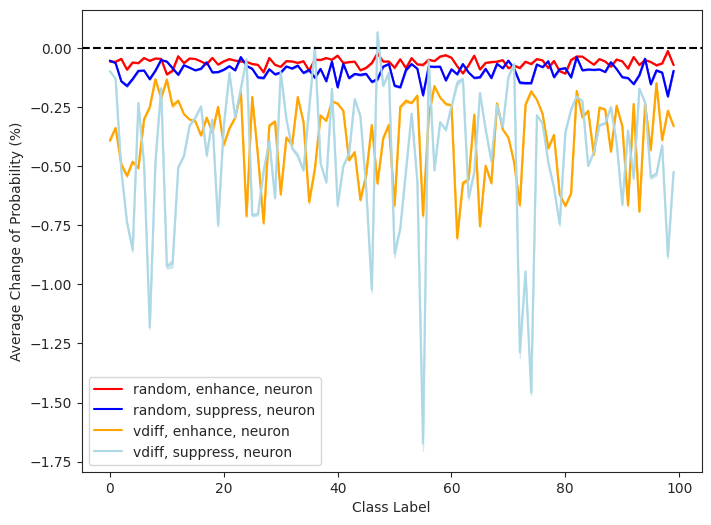

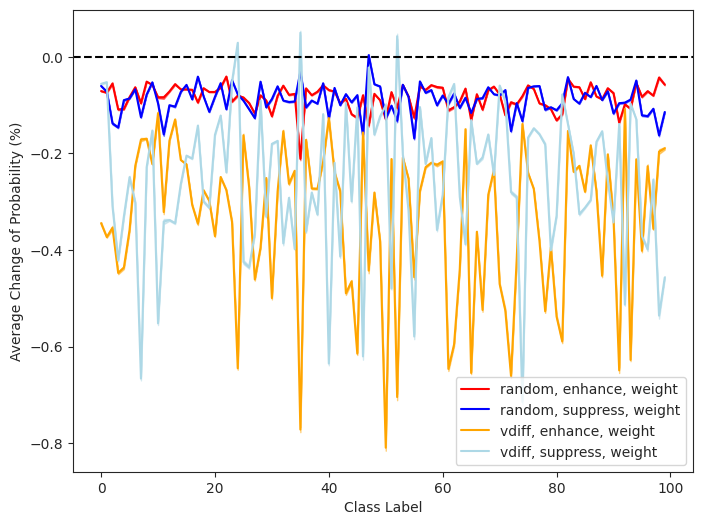

In [6]:
for target in grouped_df["fl_target"].unique():
    # op, fl_method, fl_targetの組み合わせごとにdiff_probaの平均をプロット
    plt.figure(figsize=(8, 6))
    color_list = ["red", "blue", "orange", "lightblue", "green", "yellow", "purple", "brown", "pink", "gray"]
    for i, (fl_method, fl_target, op) in enumerate(
        product(grouped_df["fl_method"].unique(), [target], grouped_df["op"].unique())
    ):
        subset = grouped_df[(grouped_df["op"] == op) & (grouped_df["fl_method"] == fl_method) & (grouped_df["fl_target"] == fl_target)]
        plt.plot(subset["label"], subset["mean_diff_proba"], label=f"{fl_method}, {op}, {fl_target}", color=color_list[i])
        plt.fill_between(
            subset["label"],
            subset["mean_diff_proba"] - subset["std_diff_proba"],
            subset["mean_diff_proba"] + subset["std_diff_proba"],
            alpha=0.5, color=color_list[i]
        )
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Class Label")
    plt.ylabel("Average Change of Probability (%)")
    plt.legend()
    plt.show()